In [740]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector, state_fidelity

########################################################################
# 2.1. Basic Shor Encoding (Classical Implementation: 2 CNOTs, H, 6 CNOTs)
########################################################################

reg, clas_reg = None, None

def shor_encode_3(qc, qubits):

    # (1) Triple repetition for Z-error protection
    qc.cx(qubits[0], qubits[3])
    qc.cx(qubits[0], qubits[6])

def shor_encode_9(qc, qubits):
    """
    Encode qubits[0] into a block of 9 physical qubits.
    Steps (classical perspective):
     - 2 CNOTs for triple repetition
     - Hadamards
     - 6 CNOTs for the second repetition
    """
    # (2) For each of the 3 qubits above, do H + 2 CNOTs => total 3 * (1 H + 2 CNOTs) = 3 H + 6 CNOT
    # block 1: qubits[0] -> qubits[3], qubits[4]
    qc.h(qubits[0])
    qc.cx(qubits[0], qubits[1])
    qc.cx(qubits[0], qubits[2])
    
    # block 2: qubits[1] -> qubits[5], qubits[6]
    qc.h(qubits[3])
    qc.cx(qubits[3], qubits[4])
    qc.cx(qubits[3], qubits[5])
    
    # block 3: qubits[2] -> qubits[7], qubits[8]
    qc.h(qubits[6])
    qc.cx(qubits[6], qubits[7])
    qc.cx(qubits[6], qubits[8])
    return qc
    


########################################################################
# 2.2. Partial Decode to 3 "Logical" Qubits 
#     (Remove the H + 2*CNOT part only)
########################################################################

def shor_partial_decode(qc, qubits_9):
    """
    Invert the second-layer encoding on each triple block:
     - 2 CNOT + H
    Leaves us with 3 qubits that are still triple-repetition for Z-protection.
    We'll place them in qubits_9[0], qubits_9[1], qubits_9[2].
    The others become disentangled (ideally).
    """
    # block 1: [0,3,4]
    qc.cx(qubits_9[0], qubits_9[2])
    qc.cx(qubits_9[0], qubits_9[1])
    # qc.h(qubits_9[0])
    
    # block 2: [1,5,6]
    qc.cx(qubits_9[3], qubits_9[5])
    qc.cx(qubits_9[3], qubits_9[4])
    # qc.h(qubits_9[3])
    
    # block 3: [2,7,8]
    qc.cx(qubits_9[6], qubits_9[8])
    qc.cx(qubits_9[6], qubits_9[7])
    # qc.h(qubits_9[6])
    return qc


########################################################################
# 2.4. Full Decode from 9 qubits to 1 
#      (the triple repetition part => 2 CNOT)
########################################################################

def shor_final_decode(qc, qubits_9):
    """
    Remove the triple repetition for Z error protection.
    We do the inverse of '2 CNOTs' from the first step of encoding.
    After that, qubit[0] is the single recovered logical qubit.
    """
    qc.h(0)
    qc.h(3)
    qc.h(6)

    qc.cx(qubits_9[0], qubits_9[3])
    qc.cx(qubits_9[0], qubits_9[6])
    return qc

########################################################################
# 2.5. Utility: Toffoli among 3 qubits
########################################################################

def apply_3_toffoli_gates(qc, qubits_9):
    """
    Apply 3 distinct Toffoli gates among these 3 qubits in some pattern.
    For example:
      Toffoli(0,1 -> 2)
      Toffoli(0,2 -> 1)
      Toffoli(1,2 -> 0)
    """
    # Gate 1
    qc.ccx(qubits_9[2], qubits_9[1], qubits_9[0])
    # Gate 2
    qc.ccx(qubits_9[5], qubits_9[4], qubits_9[3])
    # Gate 3
    qc.ccx(qubits_9[8], qubits_9[7], qubits_9[6])
    return qc

def apply_one_toffoli_among_3(qc, qubits_3):
    """
    Apply one more Toffoli gate that uses the 3 qubits.
    Let's do a standard Toffoli(0,1->2).
    """
    qc.ccx(qubits_3[6], qubits_3[3], qubits_3[0])
    return qc

########################################################################
# 2.6. Full "Classical" Shor Code Circuit with 
#      - Encode (9 qubits total)
#      - Error in the middle
#      - Partial Decode => 3 logical qubits
#      - 3 Toffoli gates among them
#      - 1 more Toffoli among them
#      - Re-Encode => 9 qubits
#      - Final Decode => 1 qubit
########################################################################

def build_shor_toffoli_circuit(error_in_middle=False, p_bit=0, p_phase=0):
    global reg, clas_reg
    """
    Build a circuit that:
      1) Prepares a test state on qubit 0
      2) Fully encodes into 9 qubits
      3) (Optionally) applies an error or noise in the middle
      4) Partially decodes to get 3 logical qubits
      5) Apply 3 Toffoli gates among these 3 logical qubits
      6) Apply 1 more Toffoli among the same 3
      7) Re-encode them to get back 9 qubits
      8) Final decode to 1 qubit
      9) Measure

    We will test how well this pipeline corrects errors.
    """
    reg = QuantumRegister(9)
    clas_reg = ClassicalRegister(1)
    qc = QuantumCircuit(reg, clas_reg)
    
    # 1) Prepare an example single-qubit state (|0> + i|1>)/sqrt(2)
    
    

    init_circuit(qc)
    # qc.s(0)

    shor_encode_3(qc, range(9))

        # 2) Full encode to 9 qubits
    shor_encode_9(qc, range(9))

    
    # 3) An optional place to insert a single-qubit error 
    #    or rely on the noise model for gate errors.

    # qc.x(0)
    # qc.x(3)
    # qc.x(6)
    # qc.h(3)
    # for i in range(9):
    #     qc.x(i)

    if error_in_middle:
        
        for i in range(9):
            if np.random.choice([False, True], p=[1-p_bit, p_bit]): qc.x(i)
            if np.random.choice([False, True], p=[1-p_phase, p_phase]): qc.z(i)

        # qc.z(0)
        # qc.z(1)
        # Example: X error on qubit 4
        
        # qc.x(0)
        # qc.z(0)
        # qc.z(1)
        # qc.id(2)
        # qc.id(3)
        # qc.id(4)
        # qc.x(5)
        # qc.id(6)
        # qc.id(7)
        # qc.id(8)

        # qc.z(0)
        # qc.z(4)
        # qc.id(8)

        pass
    
    # 4) Partial decode => 3 logical qubits are [0,1,2]
    shor_partial_decode(qc, range(9))
    
    # 5) 3 Toffoli gates among qubits [0,1,2]
    apply_3_toffoli_gates(qc, range(9))

    # 8) Final decode => single qubit is qubit 0
    shor_final_decode(qc, range(9))
    
    # 6) 1 more Toffoli among these 3
    apply_one_toffoli_among_3(qc, range(9))

    simulated_state = Statevector.from_instruction(qc)

    # qc.x(1)
    # qc.x(2)
    # qc.h(4)
    # qc.h(5)
    # qc.h(7)
    # qc.h(8)
    
    # 9) Measure
    for num, i in enumerate([0]):
    # for num, i in enumerate([0, 3, 6]):
    # for num, i in enumerate([0, 1, 2]):
        qc.measure(i, num)
    
    return qc, simulated_state

def build_no_corr_circuit(error_in_middle=False, p_bit=0, p_phase=0):
    global no_corr_reg

    no_corr_reg = QuantumRegister(1)
    no_corr_clas_reg = ClassicalRegister(1)
    qc = QuantumCircuit(no_corr_reg, no_corr_clas_reg)

    init_circuit(qc)

    qc.x(0)

    if error_in_middle:
        if np.random.choice([False, True], p=[1-p_bit, p_bit]): qc.x(0)
        if np.random.choice([False, True], p=[1-p_phase, p_phase]): qc.z(0)

    qc.id(0)

    simulated_state = Statevector.from_instruction(qc)

    qc.measure(0, 0)
    
    return qc, simulated_state


def init_circuit(qc):
    # qc.h(0)
    # qc.rz(np.pi/4, 0)
    qc.h(0)

    qc.s(0)

    return qc



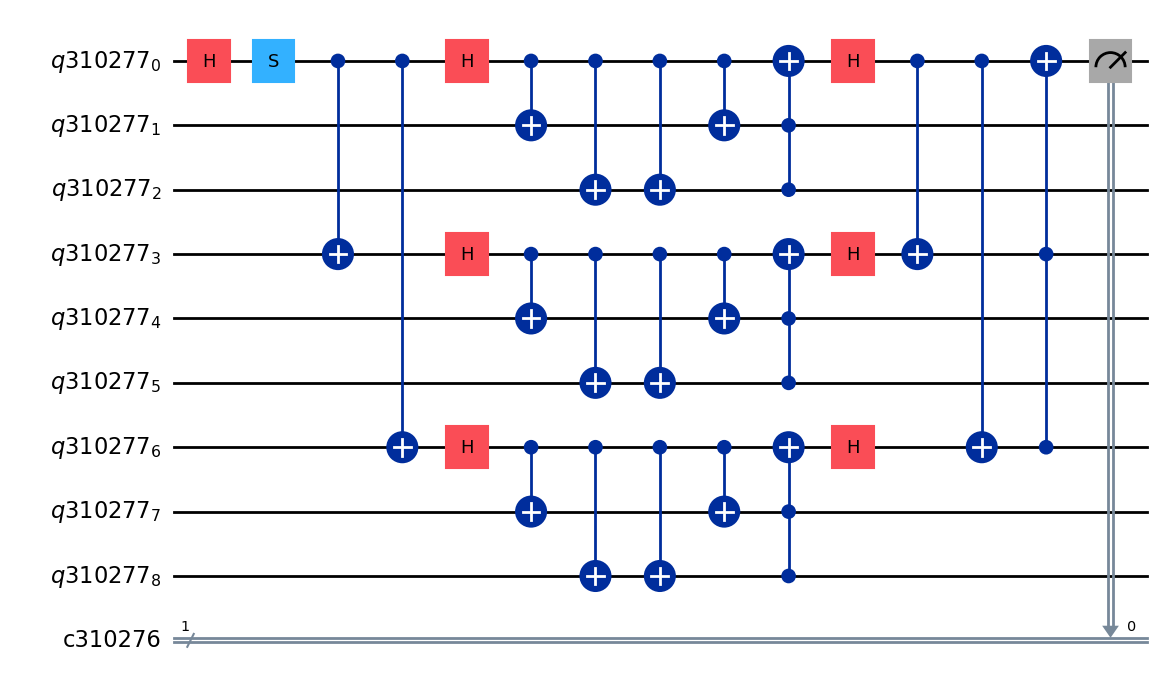

In [741]:
_         , target_state = build_shor_toffoli_circuit(error_in_middle=False)
circuit, corrected_state = build_shor_toffoli_circuit(error_in_middle=True, p_phase=0.07, p_bit=0.07)


_, single_state = build_no_corr_circuit(error_in_middle=False)

circuit.draw('mpl', style={'name': 'iqx'})

In [732]:
from qiskit.quantum_info import partial_trace

# Calculate fidelity
traced_over_qubits = [ circuit.qubits.index(qubit) for qubit in reg[[1, 2, 3, 4, 5, 6, 7, 8]]]
target_state_matr = partial_trace(target_state, traced_over_qubits)
corrected_state_matr = partial_trace(corrected_state, traced_over_qubits)

fidelity = state_fidelity(target_state_matr, corrected_state_matr)
print("State Fidelity:", fidelity)

State Fidelity: 0.9999999999999971


In [739]:
from qiskit.quantum_info import partial_trace

# Calculate fidelity
traced_over_qubits = [ circuit.qubits.index(qubit) for qubit in reg[[1, 2, 3, 4, 5, 6, 7, 8]]]
simulated_state_matr = partial_trace(simulated_state, traced_over_qubits)

fidelity = state_fidelity(single_state, simulated_state_matr)
print("State Fidelity:", fidelity)

State Fidelity: 0.9999999999999988


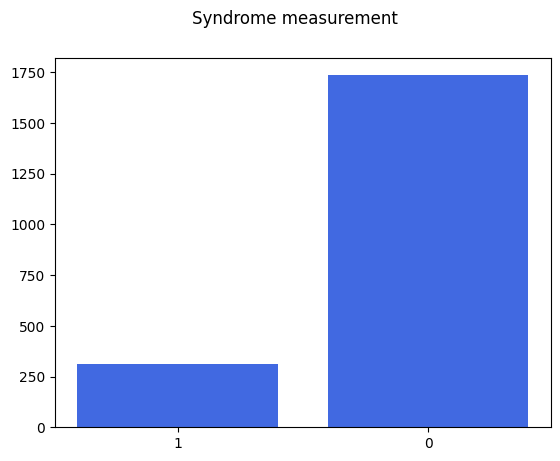

{'1': 313, '0': 1735}


In [537]:
backend = QasmSimulator()
shots = 2048

results = backend.run(circuit, shots=shots).result()
answer = results.get_counts()

keys = list(answer.keys())

plt.suptitle("Syndrome measurement")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

In [655]:
import math

def shor_correctable_probability(p_bit, p_phase):
    def binomial_coeff(n, k):
        return math.comb(n, k)

    # No errors
    P_no_bit = (1 - p_bit)**9 
    P_no_phase = (1 - p_phase)**9

    # 1-qubit errors
    P_1_bit = binomial_coeff(9, 1) * p_bit * (1 - p_bit)**8
    P_1_phase = binomial_coeff(9, 1) * p_phase * (1 - p_phase)**8

    # 2-qubit errors
    P_2_bit = binomial_coeff(9, 1) * binomial_coeff(6, 1) * p_bit**2 * (1 - p_bit)**7 / 2
    P_2_phase = binomial_coeff(9, 1) * binomial_coeff(2, 1) * p_phase**2 * (1 - p_phase)**7 / 2

    # 3-qubit errors
    P_3_bit = binomial_coeff(9, 1) * binomial_coeff(6, 1) * binomial_coeff(3, 1) * p_bit**3 * (1 - p_bit)**6 / 6
    P_3_phase = binomial_coeff(9, 1) * binomial_coeff(2, 1) * binomial_coeff(1, 1) * p_phase**3 * (1 - p_phase)**6 / 6

    # Total success probability
    P_success = (P_no_bit + P_1_bit + P_2_bit + P_3_bit) *(P_no_phase + P_1_phase  + P_2_phase +  P_3_phase)
    return P_success

# Example: Calculate fidelity
p_bit = 0.2
p_phase = 0.0
fidelity = shor_correctable_probability(p_bit, p_phase)
print(f"Fidelity with error correction: {fidelity}")

Fidelity with error correction: 0.7193231360000004


In [656]:
import math

def no_corr_probability(p_bit, p_phase):
    
    return (1-p_bit) * (1-p_phase)

# Example: Calculate fidelity
p_bit = 0.2
p_phase = 0.0
fidelity = no_corr_probability(p_bit, p_phase)
print(f"Fidelity no correction: {fidelity}")

Fidelity no correction: 0.8


In [671]:
from qiskit.quantum_info import partial_trace
from tqdm import tqdm

N_phase = 10
N_bit = 10
N_trials = 1000

p_phase_list = np.linspace(0, 0.1, N_phase)
p_bit_list = np.linspace(0, 0.1, N_bit)

fidelity_exp_list = np.zeros((N_phase, N_bit))
fidelity_theor_list = np.zeros((N_phase, N_bit))
fidelity_no_corr_exp_list = np.zeros((N_phase, N_bit))
fidelity_no_corr_theor_list = np.zeros((N_phase, N_bit))


_, target_state = build_shor_toffoli_circuit(error_in_middle=False)
target_state_matr = partial_trace(target_state, traced_over_qubits)
for i, p_phase in enumerate(tqdm(p_phase_list)):
    for j, p_bit in enumerate(p_bit_list):
        for k in range(N_trials):
            circuit, simulated_state = build_shor_toffoli_circuit(error_in_middle=True, p_phase=p_phase, p_bit=p_bit)
            # Calculate fidelity
            traced_over_qubits = [ circuit.qubits.index(qubit) for qubit in reg[[1, 2, 3, 4, 5, 6, 7, 8]]]
            simulated_state_matr = partial_trace(simulated_state, traced_over_qubits)
            fidelity = state_fidelity(target_state_matr, simulated_state_matr)
            fidelity_exp_list[i, j] += fidelity


            circuit, simulated_state = build_no_corr_circuit(error_in_middle=True, p_phase=p_phase, p_bit=p_bit)
            fidelity = state_fidelity(target_state_matr, simulated_state)
            fidelity_no_corr_exp_list[i, j] += fidelity

        fidelity_exp_list[i, j] /= N_trials
        fidelity_theor_list[i, j] = shor_correctable_probability(p_bit, p_phase)
        fidelity_no_corr_exp_list[i, j] /= N_trials 
        fidelity_no_corr_theor_list[i, j] = no_corr_probability(p_bit, p_phase)
        



100%|██████████| 10/10 [02:56<00:00, 17.64s/it]


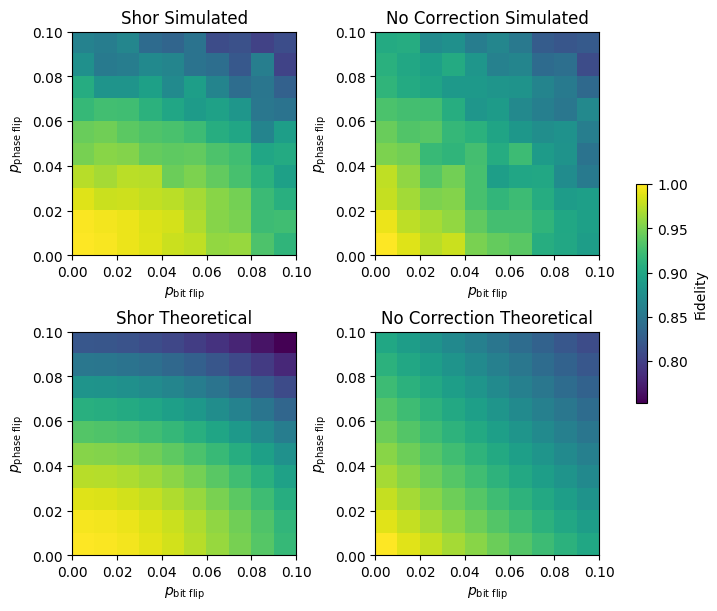

In [676]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from qiskit.quantum_info import partial_trace, state_fidelity

# Determine global color scale limits
vmin = min(fidelity_exp_list.min(), fidelity_theor_list.min(), fidelity_no_corr_exp_list.min(), fidelity_no_corr_theor_list.min())
vmax = max(fidelity_exp_list.max(), fidelity_theor_list.max(), fidelity_no_corr_exp_list.max(), fidelity_no_corr_theor_list.max())

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
cmap = 'viridis'

extent = [p_bit_list.min(), p_bit_list.max(), p_phase_list.min(), p_phase_list.max()]

# Plot each subplot using the same color scale
im1 = axes[0, 0].imshow(fidelity_exp_list, cmap=cmap, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Shor Simulated')
axes[0,0].set_xlabel('$p_{\\text{bit flip}}$')
axes[0,0].set_ylabel('$p_{\\text{phase flip}}$')

im3 = axes[0,1].imshow(fidelity_no_corr_exp_list, cmap=cmap, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
axes[0,1].set_title('No Correction Simulated')
axes[0,1].set_xlabel('$p_{\\text{bit flip}}$')
axes[0,1].set_ylabel('$p_{\\text{phase flip}}$')

im2 = axes[1,0].imshow(fidelity_theor_list, cmap=cmap, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
axes[1,0].set_title('Shor Theoretical')
axes[1,0].set_xlabel('$p_{\\text{bit flip}}$')
axes[1,0].set_ylabel('$p_{\\text{phase flip}}$')

im3 = axes[1,1].imshow(fidelity_no_corr_theor_list, cmap=cmap, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
axes[1,1].set_title('No Correction Theoretical')
axes[1,1].set_xlabel('$p_{\\text{bit flip}}$')
axes[1,1].set_ylabel('$p_{\\text{phase flip}}$')

# Add a shared colorbar for all plots
cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Fidelity')



plt.show()

In [680]:
theoretical_mask = fidelity_theor_list >= fidelity_no_corr_theor_list
experimental_mask = fidelity_exp_list >= fidelity_no_corr_exp_list 

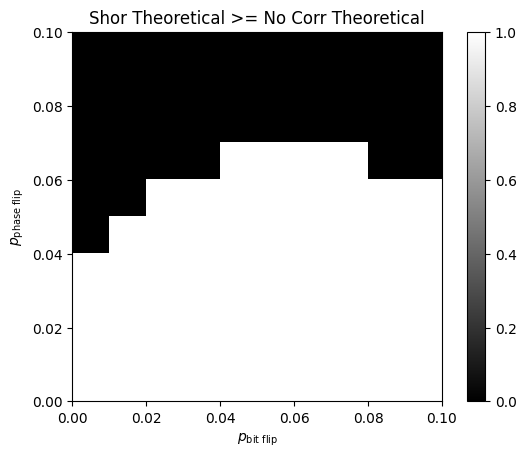

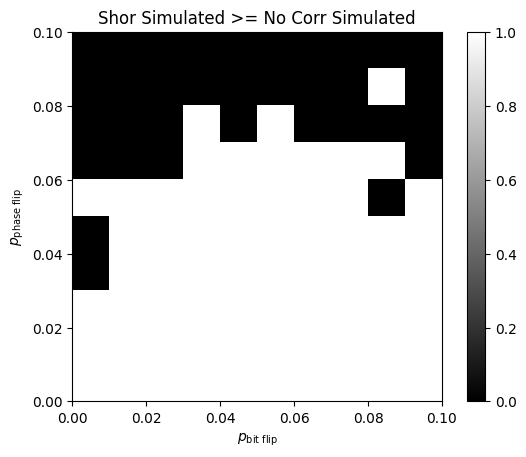

In [682]:
plt.imshow(theoretical_mask, cmap='gray', origin='lower', extent=extent)
plt.colorbar()
plt.title('Shor Theoretical >= No Corr Theoretical')
plt.xlabel('$p_{\\text{bit flip}}$')
plt.ylabel('$p_{\\text{phase flip}}$')

plt.show()

plt.imshow(experimental_mask, cmap='gray', origin='lower', extent=extent)
plt.colorbar()
plt.title('Shor Simulated >= No Corr Simulated')
plt.xlabel('$p_{\\text{bit flip}}$')
plt.ylabel('$p_{\\text{phase flip}}$')
plt.show()